# Part I

I will use the same VAE architecture as before but set the latent variable $z$ to be $\gamma \sim N(0, 30)$ and have the model predict allele age from $X_l$.  

In [567]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow.keras.backend as kb
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import numpy as np
import os
import sys
import itertools as it

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [472]:
#df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")
df1 = pd.read_csv("~/selCoefEst/traindata/trip-2021-10-20.csv")
dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

(array([2.3105e+04, 1.1010e+03, 4.4800e+02, 1.9000e+02, 1.0100e+02,
        3.0000e+01, 1.0000e+01, 8.0000e+00, 3.0000e+00, 4.0000e+00]),
 array([1.0000e+00, 4.2320e+03, 8.4630e+03, 1.2694e+04, 1.6925e+04,
        2.1156e+04, 2.5387e+04, 2.9618e+04, 3.3849e+04, 3.8080e+04,
        4.2311e+04]),
 <BarContainer object of 10 artists>)

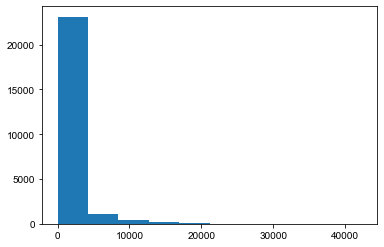

In [473]:
plt.hist(dat[:,2])

In [440]:
# get indices of ECDF sims using same test_train split seed
sims = pd.read_csv("traindata/sims-2021-10-20.csv.gz", compression='gzip', header=None)

In [493]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Part II

Below, I will ask the BaselineNet to learn the parameters of a $N(\mu, \sigma^2=0.25)$ since the $\log(a_l)$ is distributed normally, compared to the raw allele ages that are $\Gamma$ distributed. 

In [688]:
# gamma = np.unique(dat[:,1])
# idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]
# temp = [train_test_split(dat[idx[i][0],0], dat[idx[i][0],2], test_size=0.15, random_state=42) for i in np.arange(len(gamma))]

# # for each gamma value...
# Xltrain = []
# Xltest = []
# altrain = []
# altest = []
# for t in np.arange(len(temp)):
#     Xltrain.append(temp[t][0])
#     Xltest.append(temp[t][1])
#     altrain.append(temp[t][2])
#     altest.append(temp[t][3])

# train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
# train_labs = np.log(np.hstack(altrain[0:50]))

# test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
# test_labs = np.log(np.hstack(altest[0:50]))

# train_data, test_data, train_labs, test_labs = train_test_split(np.vstack((np.log(dat[:,(0)]), dat[:,1])).T, np.log(dat[:,2]), test_size=0.15, random_state=42)

## only choose data that have negative gamma and choose few frequencies for testing
dat_red = dat[dat[:,2]>1,:]
# # subsetting gamma=-100 and -0.1
# dat_red = np.vstack((dat_red[dat_red[:,1]==-100,:],dat_red[dat_red[:,1]==-1,:]))

train_data, test_data, train_labs, test_labs = train_test_split(np.vstack((np.log(dat_red[:,0]), dat_red[:,1])).T, np.log(dat_red[:,2]), test_size=0.15, random_state=42)

0.0

(array([1987., 2038., 2365., 2531., 2316., 1972., 1733., 1470., 1018.,
         162.]),
 array([ 0.69314718,  1.6891127 ,  2.68507822,  3.68104374,  4.67700926,
         5.67297478,  6.6689403 ,  7.66490582,  8.66087134,  9.65683686,
        10.65280238]),
 <BarContainer object of 10 artists>)

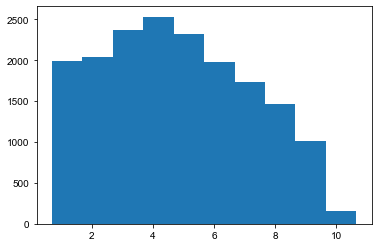

In [689]:
plt.hist(train_labs)

Text(0, 0.5, 'log-age')

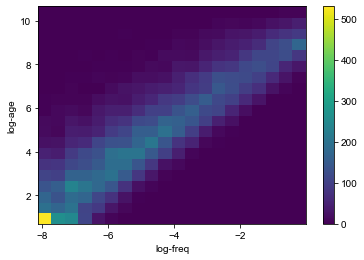

In [690]:
plt.hist2d(train_data[:,0], train_labs, [20,20])
plt.colorbar()
plt.xlabel('log-freq')
plt.ylabel('log-age')

In [504]:
counts, binsfreq, binsage = np.histogram2d(train_data[:,0], train_labs, [20,20])

In [505]:
## downsampling to a fixed number of points in each bin ~
subsampled = []
for i in range(len(binsage)-1):
    for j in range(len(binsfreq)-1):
        if counts[j, i]>250:
            section = np.random.choice(np.where((train_data[:,0]>=binsfreq[j]) & (train_data[:,0]<binsfreq[j+1]) & (train_labs>=binsage[i]) & (train_labs<binsage[i+1]))[0], 250, replace=False)
            subsampled.append(section)
        else:
            subsampled.append(np.where((train_data[:,0]>=binsfreq[j]) & (train_data[:,0]<binsfreq[j+1]) & (train_labs>=binsage[i]) & (train_labs<binsage[i+1]))[0])

(array([296.,  25.,  23.,  20.,  16.,  11.,   4.,   1.,   1.,   3.]),
 array([  0. ,  52.1, 104.2, 156.3, 208.4, 260.5, 312.6, 364.7, 416.8,
        468.9, 521. ]),
 <BarContainer object of 10 artists>)

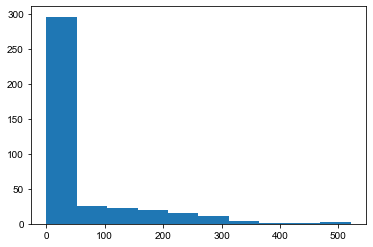

In [277]:
# print(i, j)
# print(counts[i, j])
# len(np.where((train_data[:,0]>=binsfreq[j]) & (train_data[:,0]<binsfreq[j+1]) & (train_labs>=binsage[i]) & (train_labs<binsage[i+1]))[0])

Text(0, 0.5, 'log-age')

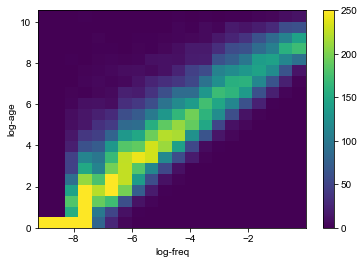

In [506]:
flatidx = [item for sublist in subsampled for item in sublist]
plt.hist2d(train_data[flatidx,0], train_labs[flatidx], [20,20])
plt.colorbar()
plt.xlabel('log-freq')
plt.ylabel('log-age')

In [507]:
## after downsampling - not losing too many points...
print(train_data.shape)
train_data = train_data[flatidx,:]
train_labs = train_labs[flatidx]
train_data.shape

(21250, 2)


(18421, 2)

In [447]:
sims_train, sims_test = train_test_split(sims.iloc[:,np.array(dat[:,1]<0)].T, test_size=0.15, random_state=42)

In [7]:
np.log(dat[:,1])

array([       nan,        nan,        nan, ..., 3.83764186, 4.22140605,
       4.60517019])

### Augmenting training data with more samples from the simulations

I will increase the size of the training data set by adding in 50 allele ages from the simulations to help with estimation of sd (i.e., each pair of $X_l,\gamma$ will have 50 samples of allele age). 

In [662]:
xlength = 25
for j in range(len(train_data)):
    train_data = np.append(train_data, np.repeat(dat[j,(0,1)],xlength).reshape(-1,2,order='F'), axis=0)
    train_labs = np.append(train_labs, np.log(sims_train.iloc[j,0:xlength]))

In [655]:
newtrain = np.append(train_data, np.repeat(dat[0,(0,1)],10).reshape(-1,2,order='F'), axis=0)

In [661]:
np.append(train_labs, np.log(sims_train.iloc[0,0:10]))

(42510,)

In [520]:
train_labs.shape

(21250,)

In [701]:
## NO IMPROVEMENT IN ESTIMATION BY INCREASING NUMBER OF HIDDEN LAYERS AND NODES
## TAKES LONGER TO CONVERGE WHEN USING SIGMOID VS RELU
x = keras.Input(shape=(2,))
h = Dense(128, activation='relu', kernel_initializer='random_uniform')(x)
h = Dense(64, activation='relu', kernel_initializer='random_uniform')(h)
h = Dense(16, activation='relu', kernel_initializer='random_uniform')(h)
params = Dense(1, kernel_initializer='random_uniform')(h)

## having just 1 free parameter works well...
# output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(tf.math.softplus(t[:,0]), 0.15))(params)

#output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(t[...,:1], 2.*tf.math.exp(t[...,1:])))(params)
output = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Exponential(tf.math.exp(t[...,0])))(params)

prob_model = keras.Model(inputs=x, outputs=output)

# def nll(yt, params):
#     dist = tfp.distributions.Normal(params, 1.0)
#     return tf.reduce_sum(-dist.log_prob(yt))
negloglik = lambda y, p_y: -tf.reduce_sum(p_y.log_prob(y))

#param_model = keras.Model(prob_model.input, params)

prob_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

(array([783., 371., 377., 540., 447., 402., 319., 287., 182.,  42.]),
 array([ 0.        ,  1.06528024,  2.13056048,  3.19584071,  4.26112095,
         5.32640119,  6.39168143,  7.45696166,  8.5222419 ,  9.58752214,
        10.65280238]),
 <BarContainer object of 10 artists>)

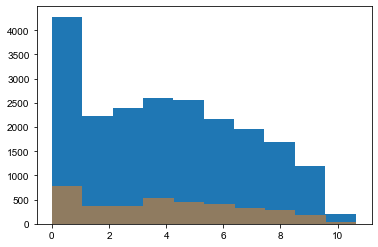

In [626]:
plt.hist(train_labs)
plt.hist(test_labs, alpha=0.5)

(array([1.5973e+04, 9.4600e+02, 3.8600e+02, 1.5800e+02, 8.3000e+01,
        2.8000e+01, 8.0000e+00, 4.0000e+00, 2.0000e+00, 4.0000e+00]),
 array([2.00000e+00, 4.23290e+03, 8.46380e+03, 1.26947e+04, 1.69256e+04,
        2.11565e+04, 2.53874e+04, 2.96183e+04, 3.38492e+04, 3.80801e+04,
        4.23110e+04]),
 <BarContainer object of 10 artists>)

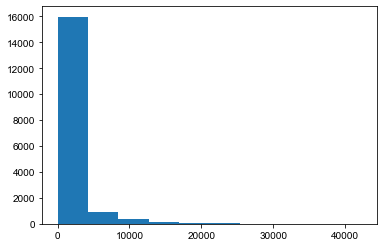

In [706]:
plt.hist(np.exp(train_labs))

In [704]:
prob_model.fit(train_data, train_labs, batch_size=512, epochs=5, shuffle=True)

Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: nan
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: nan
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: nan
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: nan
Epoch 5/5
35/35 [==============================] - 0s 3ms/step - loss: nan


In [703]:
history = prob_model.fit(train_data, train_labs, epochs=500, batch_size=1024, verbose=0, validation_split=0.1, shuffle=True, callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


.........................................................

KeyboardInterrupt: 

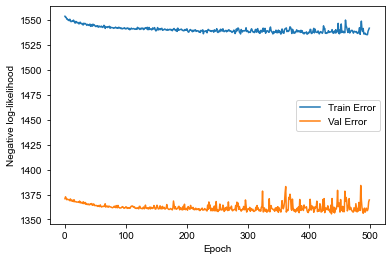

In [693]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Negative log-likelihood')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

In [694]:
ahat = prob_model(test_data)
preds = np.exp(ahat.mean().numpy())
preds_sd = ahat.stddev().numpy()

In [665]:
## save the model 
prob_model.save('saved_model/lognorm_model')

INFO:tensorflow:Assets written to: saved_model/lognorm_model/assets


In [648]:
## read-in saved model (no retraining required)
prob_model = tf.keras.models.load_model('saved_model/lognorm_model', compile=False)
negloglik = lambda y, p_y: -tf.reduce_sum(p_y.log_prob(y))
# compile the loaded model with the custome objects
prob_model.compile(optimizer='adam', loss=negloglik)

(array([412., 492., 357., 343., 285., 279., 236., 262., 238., 201.]),
 array([1.5451132, 2.2955403, 3.0459673, 3.7963946, 4.5468216, 5.297249 ,
        6.0476756, 6.798103 , 7.54853  , 8.298957 , 9.049384 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

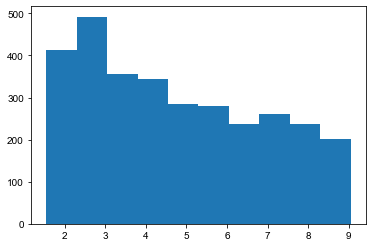

In [697]:
plt.hist(np.log(preds[:,0]))

(array([2386.,  249.,  119.,  100.,   64.,   54.,   47.,   29.,   27.,
          30.]),
 array([4.6885023e+00, 8.5554895e+02, 1.7064094e+03, 2.5572698e+03,
        3.4081304e+03, 4.2589907e+03, 5.1098511e+03, 5.9607114e+03,
        6.8115723e+03, 7.6624326e+03, 8.5132930e+03], dtype=float32),
 <BarContainer object of 10 artists>)

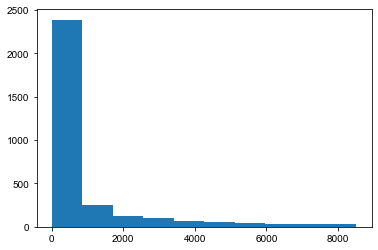

In [696]:
plt.hist(preds)

## Diagnostic measures

Below, I have code to procude plots and statistics for accuracy measures 

Text(8, 3, 'Intercept = 1.00')

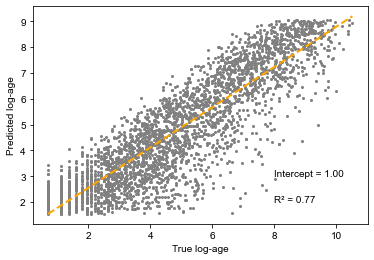

In [698]:
plt.ylabel('Predicted log-age')
plt.xlabel('True log-age')
plt.plot(test_labs, np.log(preds), 'o', color='grey', markersize=2)
res = sm.OLS(np.log(preds), sm.add_constant(test_labs)).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(test_labs), np.max(test_labs), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(8, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(8, 3, "Intercept = {:.2f}".format(muhat))

Text(14000, 2500, 'Intercept = 378.16')

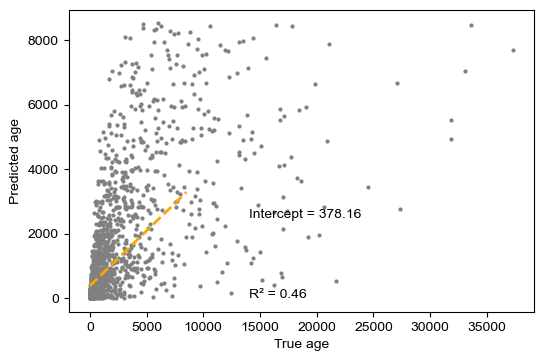

In [699]:
plt.figure(dpi=100)
plt.ylabel('Predicted age')
plt.xlabel('True age')
plt.plot(np.exp(test_labs), preds, 'o', color='grey', markersize=2)
res = sm.OLS(preds, sm.add_constant(np.exp(test_labs))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds), np.max(preds), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(14000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(14000, 2500, "Intercept = {:.2f}".format(muhat))

In [700]:
# check if true values fall within 95% CI of the estimates
inctr = np.full(len(test_labs), False, dtype='bool')
for i in range(len(test_labs)):
    lb, ub = np.exp(np.log(preds[i]) - 1.96*preds_sd[i]), np.exp(np.log(preds[i]) + 1.96*preds_sd[i])
    if np.exp(test_labs[i])>=lb and np.exp(test_labs[i])<=ub:
        inctr[i] = True

print('Accuracy: {:.2f}%'.format(100*np.sum(inctr)/len(test_labs)))

# check if true values fall within 95% CI of the estimates for the top right quadrant
tot = np.where((test_labs<4) & (test_data[:,0]<-4))[0]
inctr = np.full(len(tot), False, dtype='bool')
for ctr, i in enumerate(tot):
    lb, ub = np.exp(np.log(preds[i]) - 1.96*preds_sd[i]), np.exp(np.log(preds[i]) + 1.96*preds_sd[i])
    if np.exp(test_labs[i])>=lb and np.exp(test_labs[i])<=ub:
        inctr[ctr] = True

print('Accuracy for small vals: {:.2f}%'.format(100*np.sum(inctr)/len(tot)))

Accuracy: 95.39%
Accuracy for small vals: 99.92%


(array([97.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([7.54424958e-02, 7.84407246e+01, 1.56806007e+02, 2.35171289e+02,
        3.13536571e+02, 3.91901853e+02, 4.70267135e+02, 5.48632417e+02,
        6.26997700e+02, 7.05362982e+02, 7.83728264e+02]),
 <BarContainer object of 10 artists>)

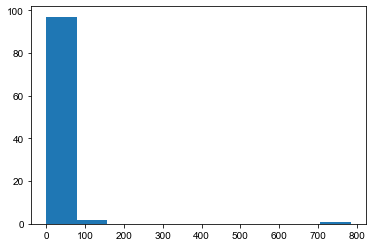

In [549]:
plt.hist(np.exp(np.random.normal(np.log(preds[2]),preds_sd[2],100)))

(array([3010.,  194.,  114.,   90.,   63.,   66.,   62.,   69.,   51.,
          31.]),
 array([9.8191446e-01, 8.1429913e+02, 1.6276163e+03, 2.4409336e+03,
        3.2542507e+03, 4.0675679e+03, 4.8808853e+03, 5.6942021e+03,
        6.5075195e+03, 7.3208364e+03, 8.1341538e+03], dtype=float32),
 <BarContainer object of 10 artists>)

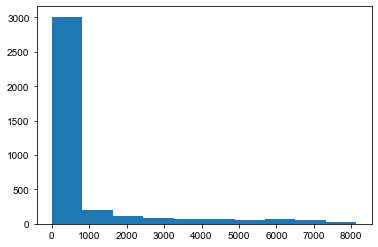

In [539]:
plt.hist(preds)

In [637]:
def plot_res(idx):    
    ## plot histogram of samples of allele age...
    plt.hist(np.exp(np.random.normal(np.log(preds[idx]),preds_sd[idx],200)), color="grey")
    plt.xlabel('Posterior estimate of allele age')
    plt.axvline(x=np.exp(test_labs[idx]), color="red", label="True")
    plt.axvline(x=np.exp(scipy.stats.norm.ppf(0.05, np.log(preds[idx]), preds_sd[idx])), ls='--', color='black')
    plt.axvline(x=np.exp(scipy.stats.norm.ppf(0.95, np.log(preds[idx]), preds_sd[idx])), ls='--', color='black', label='95% CI')
    plt.legend()
    plt.show()

interact(plot_res, idx=np.arange(len(preds)))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.plot_res(idx)>

In [673]:
def plot_res_log(idx):    
    ## plot histogram of samples of allele age...
    plt.hist(np.random.normal(np.log(preds[idx]),preds_sd[idx],200), color="grey")
    plt.xlabel('Posterior estimate of allele age')
    plt.axvline(x=test_labs[idx], color="red", label="True")
    plt.axvline(x=scipy.stats.norm.ppf(0.05, np.log(preds[idx]), preds_sd[idx]), ls='--', color='black')
    plt.axvline(x=scipy.stats.norm.ppf(0.95, np.log(preds[idx]), preds_sd[idx]), ls='--', color='black', label='95% CI')
    plt.legend()
    plt.show()

interact(plot_res_log, idx=np.arange(len(preds)))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.plot_res_log(idx)>

In [679]:
test_labs[980]

5.497168225293202

In [729]:
kst = np.empty((len(test_labs),2))
for i in range(len(test_labs)):
    kst[i,:] = scipy.stats.kstest(np.random.normal(np.log(preds[i]),preds_sd[i],200),np.log(sims_test.iloc[i,:]))

(0.0, 1.0)

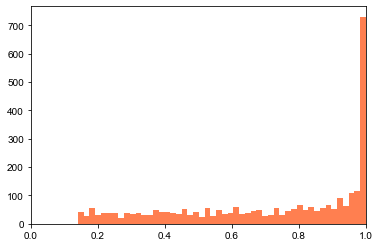

In [731]:
plt.hist(kst[kst[:,1]<0.05,0],color='coral',bins=50)
plt.xlim(0,1)

In [369]:
def get_plot_kst(xl=None, delta=0.025, gamma=None):
    """function returns or plots ks-test value for a range of Xl, gamma or Xl and gamma, 
    needs to have sims_test and preds in the global environment"""
    if xl is None:
        idx = np.where(test_data[:,1]==gamma)[0]
        idx2 = np.where(kst[idx,1]<0.05)[0]
        plt.plot(np.exp(test_data[idx,0]), kst[idx,0], 'o', color='coral', label='not significant', alpha=0.3)
        plt.plot(np.exp(test_data[idx2,0]), kst[idx2,0], 'o', color='coral', label='p ≤ 0.05')
        plt.xlabel('Allele frequency')
        plt.ylabel('KS-test')
        plt.ylim((0,1))
        plt.title("gamma={:.3f}".format(gamma))
        plt.legend()
        return 0
    elif gamma is None:
        idx = np.where(np.logical_and(np.exp(test_data[:,0])>xl-delta, np.exp(test_data[:,0])<xl+delta))[0]
        idx2 = np.where(kst[idx,1]<0.05)[0]
        plt.plot(test_data[idx,1], kst[idx,0], 'o', color='coral', label='not significant', alpha=0.3)
        plt.plot(test_data[idx2,1], kst[idx2,0], 'o', color='coral', label='p ≤ 0.05')
        plt.title("Xl in ({:.2f}, {:.2f})".format(xl-delta,xl+delta))
        plt.xlabel('gamma')
        plt.ylim((0,1))
        plt.ylabel('KS-test')
        plt.legend()
        return 0

0

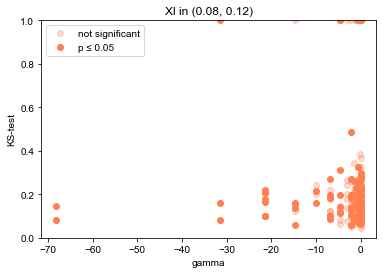

In [728]:
get_plot_kst(xl=0.1)

0

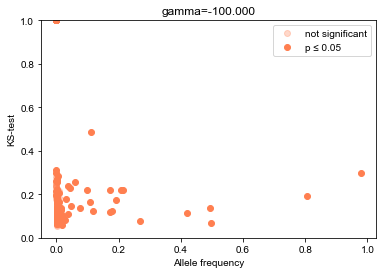

In [641]:
#get_plot_kst(gamma=-10.0)
get_plot_kst(gamma=-100.)

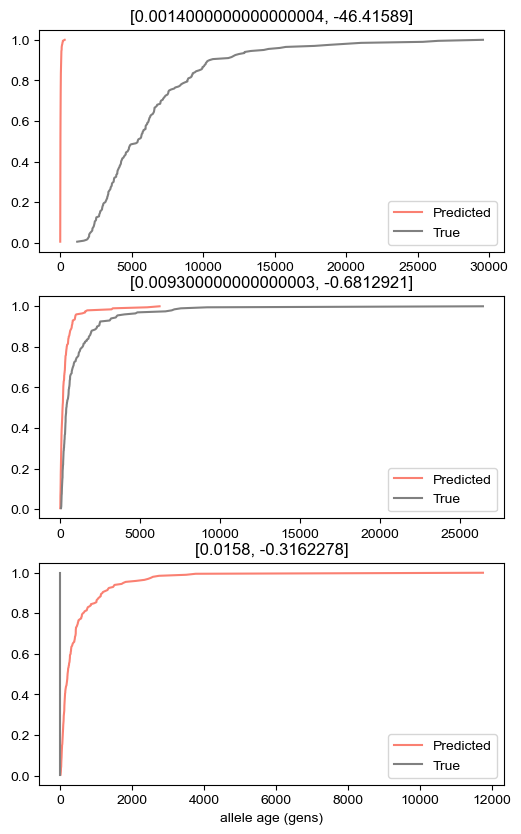

In [711]:
## compare ECDFs of the true allele ages and estimated distributions (3 examples)
# find that SD=0.1 is not great for all allele ages (as expected...)
plt.figure(dpi=100, figsize=(6,10))
plt.grid()
plt.subplot(311)
e1 = ECDF(np.exp(np.random.normal(np.log(preds[342,0]),preds_sd[342],200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.title(label=[np.exp(test_data[342,0]), test_data[342,1]])
e2 = ECDF(sims_test.iloc[342,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

plt.subplot(312)
e1 = ECDF(np.exp(np.random.normal(np.log(preds[489,0]),preds_sd[489],200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.title(label=[np.exp(test_data[489,0]), test_data[489,1]])
e2 = ECDF(sims_test.iloc[489,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

plt.subplot(313)
e1 = ECDF(np.exp(np.random.normal(np.log(preds[678,0]),preds_sd[678],200)))
plt.plot(e1.x, e1.y, color='salmon', label='Predicted')
plt.title(label=[np.exp(test_data[678,0]), test_data[678,1]])
plt.xlabel('allele age (gens)')
e2 = ECDF(sims_test.iloc[678,:])
plt.plot(e2.x, e2.y, color='grey', label='True')
plt.legend()

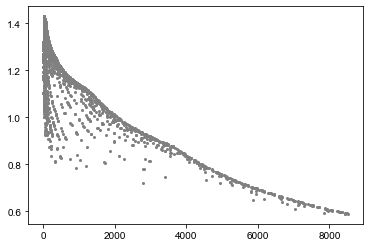

In [732]:
plt.plot(preds, preds_sd, 'o', color='grey', markersize=2)

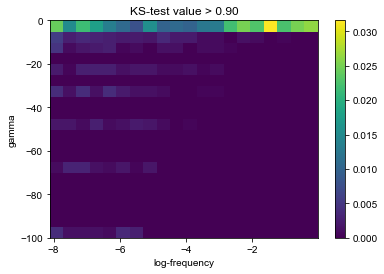

In [775]:
# query indices with highest kst (ONLY significant values)
kst_sig = np.where(np.logical_and(kst[:,1]<0.05, kst[:,0]>0.9))[0]
h_kst = plt.hist2d(test_data[kst_sig,0],test_data[kst_sig,1], [20,20], density=True)
plt.ylim((-100,0))
plt.xlabel('log-frequency')
plt.ylabel('gamma')
plt.title('KS-test value > 0.90')
plt.colorbar()

In [771]:
hx[2]

array([-1.00000e+02, -9.50005e+01, -9.00010e+01, -8.50015e+01,
       -8.00020e+01, -7.50025e+01, -7.00030e+01, -6.50035e+01,
       -6.00040e+01, -5.50045e+01, -5.00050e+01, -4.50055e+01,
       -4.00060e+01, -3.50065e+01, -3.00070e+01, -2.50075e+01,
       -2.00080e+01, -1.50085e+01, -1.00090e+01, -5.00950e+00,
       -1.00000e-02])

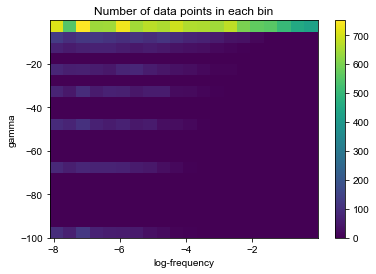

In [734]:
h_full = plt.hist2d(train_data[:,0],train_data[:,1], [20,20])
plt.title('Number of data points in each bin')
plt.xlabel('log-frequency')
plt.ylabel('gamma')
plt.colorbar()

In [1096]:
# check if .mean() and .stddev() return params or empirical values?
param_model = keras.Model(prob_model.input, params)
params = param_model(test_data)

0.999999999999997
1.0


Text(0, 0.5, 'Mean from output layer')

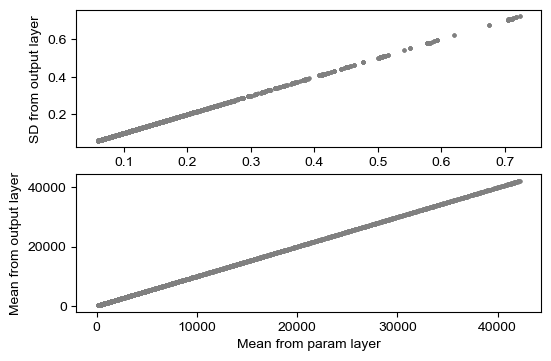

In [1098]:
# Correlation of 1 between the the two, NO NEED FOR param_model
plt.figure(dpi=100)
plt.subplot(211)
# param output is log var NOT sd
print(np.corrcoef(2.*np.exp(params[:,1].numpy()), preds_sd.T)[0,1])
plt.plot(2.*np.exp(params[:,1].numpy()), preds_sd, 'o', color='grey', markersize=2)
plt.xlabel('SD from param layer')
plt.ylabel('SD from output layer')
plt.subplot(212)
print(np.corrcoef(np.exp(params[:,0].numpy()), preds.T)[0,1])
plt.plot(np.exp(params[:,0].numpy()), preds, 'o', color='grey', markersize=2)
plt.xlabel('Mean from param layer')
plt.ylabel('Mean from output layer')

450 more pairs have significant differences with sd=0.25 when compared to sd=0.1 (best in test, increases again drastically for sd=0.05 and a little bit for sd=0.15) 


But decreasing the sd we see that a smaller percentage of 'true' values fall within the 95% CI of the estimate...seems like there is a balance at sd=0.15   

Again lowest accuracy when $|\gamma| < 0.02$ and $X_l < 5 \times 10^{-4}$ 

In [885]:
len(np.where(kst[:,1]<0.05)[0])

3120

In [963]:
np.where(np.logical_and(kst[:,1]<0.05, kst[:,0]>0.25))[0]

array([   0,    2,    3, ..., 7489, 7494, 7498])

In [502]:
scipy.stats.kstest(np.random.normal(pred_params[57,0],0.25,200),np.random.normal(pred_params[55,0],0.25,200))

0.205

In [473]:
np.linspace(0,1,200)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

## Part IV

In this section, I will test the hypothesis that by conditioning on allele age AND allele frequency we get a better likelihood estimate for selection coefficient than just conditioning on allele frequency. Naively, this means looking at the curvature of the log-likelihood surface around the estimate (say $\gamma=-10.0$) for the two different distributions: $p(\gamma | X_l)$ and $p(\gamma | X_l, a_l) = p(X_l | \gamma) p(a_l | X_l, \gamma)$. 

$$f(X_l | \gamma) = \frac{1}{X_l(1-X_l)}\frac{1-e^{-2\gamma(1-X_l)}}{1-e^{-2\gamma}}$$

In [415]:
import jax.numpy as jnp
from jax import jacrev, jacfwd, hessian
import jax

In [646]:
# subset data for a specific value of gamma=-10
Xlred = np.ravel(np.exp(test_data[np.where(test_data[:,1]==-10),0]))
logalred = test_labs[np.where(test_data[:,1]==-10)]

In [416]:
def get_ll_xl(g, Xlred, N):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    xl = Xlred#params[1]
    #N = params[2]
    res = 0.0
    ub = scipy.special.expi(-g*0.5/N) - np.exp(-g)*scipy.special.expi(g*(1-0.5/N)) - np.log(0.5/N) + np.log(1-0.5/N)
    lb = scipy.special.expi(g*(0.5/N-1)) - np.exp(-g)*scipy.special.expi(g*0.5/N) - np.log(1-0.5/N) + np.log(0.5/N)
    scalfact = np.log((ub - lb)/(1-np.exp(-g)))
    for x in xl:
        res += -np.log(x) - np.log(1.-x) + np.log((1.-np.exp(-2.*g*(1.-x)))/(1.-np.exp(-2.*g))) / scalfact
    #res = np.sum(-np.log(xl) - np.log(1.-xl) + np.log((1.-np.exp(-2.*g*(1.-xl)))/(1.-np.exp(-2.*g)))) / scalfact
    return res

In [75]:
# def get_ll_xl(gamma, xl, N=2500):
#     """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
#     res = np.zeros(len(gamma))
#     for i, g in enumerate(gamma):
#         ub = scipy.special.expi(-g*0.5/N) - np.exp(-g)*scipy.special.expi(g*(1-0.5/N)) - np.log(0.5/N) + np.log(1-0.5/N)
#         lb = scipy.special.expi(g*(0.5/N-1)) - np.exp(-g)*scipy.special.expi(g*0.5/N) - np.log(1-0.5/N) + np.log(0.5/N)
#         scalfact = np.log((ub - lb)/(1-np.exp(-g)))
#         for x in xl:
#             res[i] += -np.log(x) - np.log(1-x) + np.log((1-np.exp(-2.*g*(1-x)))/(1-np.exp(-2.*g))) / scalfact
#     return np.array(res)

# def get_ll_xl_torch(g):
#     """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
#     xl = torch.tensor(Xlred)#params[1]
#     #N = params[2]
#     res = 0.0
#     ub = scipy.special.expi(-g.detach().numpy()*0.5/N) - g.exp()*scipy.special.expi(g.detach().numpy()*(1-0.5/N)) - np.log(0.5/N) + np.log(1-0.5/N)
#     lb = scipy.special.expi(g.detach().numpy()*(0.5/N-1)) - (-g).exp()*scipy.special.expi(g.detach().numpy()*0.5/N) - np.log(1-0.5/N) + np.log(0.5/N)
#     scalfact = (ub - lb)/(1-(-g).exp())
#     for x in xl:
#         res += -x.log() - (1.-x).log() + np.log((1.-np.exp(-2.*g.detach().numpy()*(1.-x)))/(1.-np.exp(-2.*g.detach().numpy()))) 
#     #res = (-xl.log() - (1.-xl).log() + ((1.-(-2.*g*(1.-xl)).exp())/(1.-(-2.*g).exp())).log()).sum() / scalfact
#     return torch.tensor(res / scalfact.log())

def get_ll_xl_jax(g, xl, N):
    res = 0.0
    ub = jnp.exp(2.*g)*(jax.scipy.special.expi(-2.*g*0.5/N) - jnp.log(0.5/N) + jnp.log(1-0.5/N)) - jax.scipy.special.expi(2.*g*(1-0.5/N))
    lb = jnp.exp(2.*g)*(jax.scipy.special.expi(2.*g*(0.5/N-1)) - jnp.log(1-0.5/N) + jnp.log(0.5/N)) - jax.scipy.special.expi(2.*g*0.5/N)
    scalfact = jnp.log((ub - lb)/(jnp.exp(2.*g)-1))
    for x in xl:
        res += -jnp.log(x) - jnp.log(1.-x) + jnp.log((1.-jnp.exp(-2.*g*(1.-x)))/(1.-jnp.exp(-2.*g))) - scalfact
    return res 

In [376]:
#print(get_ll_xl_jax(-10.))
-jax.hessian(get_ll_xl_jax)(-10., Xlred, N=2500)
#jacrev(jacfwd(get_ll_xl_jax))(-10.) - same as jax.hessian(f)(x)

DeviceArray(0.03342272, dtype=float32)

In [392]:
np.round(5**np.arange(0,5,0.5))

array([1.000e+00, 2.000e+00, 5.000e+00, 1.100e+01, 2.500e+01, 5.600e+01,
       1.250e+02, 2.800e+02, 6.250e+02, 1.398e+03])

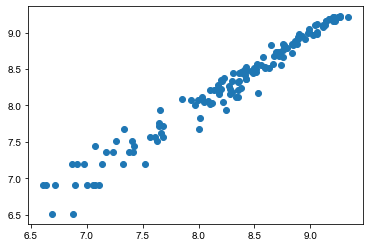

In [401]:
plt.plot(alred, predsred, 'o')

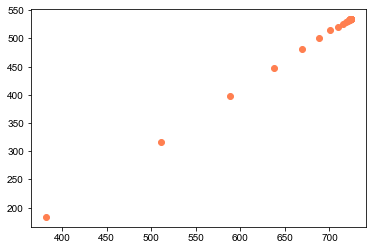

In [100]:
plt.plot(logxl, logxlal, 'o', color='coral')

In [417]:
## for gamma=-10
#obs_fi = [-jax.hessian(get_ll_xl_jax)(-10., Xlred[0:i], N=2500) for i in [1, 5, 50, 125, 625]]
plt.semilogx([1, 5, 125, 625], obs_fi, color='k', label='L(γ; Xl)')
plt.title('γ=-10.') 
plt.xlabel('Number of Sites')
plt.ylabel('Observed Fisher Information')
plt.legend()

NameError: name 'obs_fi' is not defined

(array([99., 13.,  6.,  6.,  2.,  2.,  3.,  4.,  3.,  7.]),
 array([4.000e-04, 1.002e-01, 2.000e-01, 2.998e-01, 3.996e-01, 4.994e-01,
        5.992e-01, 6.990e-01, 7.988e-01, 8.986e-01, 9.984e-01]),
 <BarContainer object of 10 artists>)

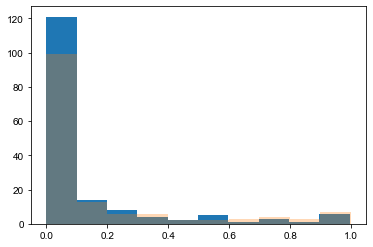

In [500]:
plt.hist(np.ravel(np.exp(test_data[np.where(test_data[:,1]==-0.1),0])))
plt.hist(Xlred,alpha=0.3)

In [418]:
# def get_ll_alxl(gamma, Xlred, lalred, model):
#     """function to compute L(gamma|Xl,al), where gamma is a range of values and Xl & al are given sets of freqs and ages"""
#     res = np.zeros(len(gamma))
#     for ig, g in enumerate(gamma):
#         ahat = model(np.vstack((np.log(Xlred),np.repeat(g,len(Xlred)))).T)
#         preds = ahat.mean().numpy()
#         preds_sd = ahat.stddev().numpy()
#         for ia, a in enumerate(lalred):
#             res[ig] += scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia]) 
#     return res

def get_ll_alxl(params):
    """function to compute L(gamma|Xl,al), where gamma is a range of values and Xl & al are given sets of freqs and ages"""
    res = 0.0
    g = params[0]
    Xlred = params[1]
    logalred = params[2]
    prob_model = params[3]

    ahat = prob_model(np.vstack((np.log(Xlred),np.repeat(g,len(Xlred)))).T)
    preds = ahat.mean().numpy()
    preds_sd = ahat.stddev().numpy()

    for ia, a in enumerate(logalred):
        res += scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia]) 
    return res

### Plotting the log-likelihood surfaces 

In [419]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from __future__ import print_function

In [647]:
def plot_func(N, g):
    Xlred = np.ravel(np.exp(test_data[np.where(test_data[:,1]==g),0]))
    logalred = test_labs[np.where(test_data[:,1]==g)]

    logxl = np.ravel([get_ll_xl(g, Xlred, N) for g in gamma[gamma<0]])
    logxlal = np.ravel([get_ll_alxl([g, Xlred, logalred, prob_model]) for g in gamma[gamma<0]]) + logxl
    fig = plt.figure(dpi=100)
    _ = plt.semilogx(gamma[gamma<0], logxl-np.max(logxl), color='k', label='L(gamma; Xl)')
    plt.xscale('symlog')
    _ = plt.semilogx(gamma[gamma<0], logxlal-np.max(logxlal), color='b', label='L(gamma; Xl, al)')
    plt.xscale('symlog')
    plt.axvline(x=g, linestyle='--', color='red', label='true value')
    plt.xlabel('gamma')
    plt.ylabel('scaled log-likelihood')
    plt.legend()
    plt.grid()
    plt.ylim((-20,1))
    plt.show()

interact(plot_func, N=2500, g=gamma[gamma<0])

interactive(children=(IntSlider(value=2500, description='N', max=7500, min=-2500), Dropdown(description='g', o…

<function __main__.plot_func(N, g)>

### Fitting a quadratic to the above log-likelihood surfaces

Below, I will fit a quaratic to the lines above - the coefficient of the squared term should reflect how much information is captured by the log-likelihood. 

In [431]:
# subsetting a valid gamma
Xlred = np.ravel(np.exp(test_data[np.where(test_data[:,1]==-10.),0]))
logalred = test_labs[np.where(test_data[:,1]==-10.)]

logxl = np.ravel([get_ll_xl(g, Xlred, N) for g in gamma[gamma<0]])
logxlal = np.ravel([get_ll_alxl([g, Xlred, logalred, prob_model]) for g in gamma[gamma<0]]) #+ logxl
logxl=logxl-np.max(logxl)
logxlal=logxlal-np.max(logxlal)

In [432]:
# return coefs of best fit quadratic line
def get_bfq(loglik, g):
    return np.polynomial.polynomial.Polynomial.fit(gamma[gamma<0], loglik, deg=2, window=[g-.5*g,g+.5*g])

In [433]:
get_bfq(logxl, -1), get_bfq(logxlal, -1.)

(Polynomial([-358.04356989, -330.27432692,  -60.81383292], domain=[-1.e+02, -1.e-02], window=[-0.5, -1.5]),
 Polynomial([-21673.83084724, -31387.64865639, -11823.33104266], domain=[-1.e+02, -1.e-02], window=[-0.5, -1.5]))

In [434]:
# running the analysis for varying number of sites and repeating 20 times for each number of sites
lxlalbfq = []
lxlbfq = []
sites = [1, 5, 50, 125, 625]
for i in sites:
    for n in np.arange(20):
        rs = np.random.randint(len(Xlred), size=i)
        logxl = np.ravel([get_ll_xl(g, Xlred[rs], N) for g in gamma[gamma<0]])
        logxlal = np.ravel([get_ll_alxl([g, Xlred[rs], logalred[rs], prob_model]) for g in gamma[gamma<0]]) #+ logxl
        lxlbfq.append(get_bfq(logxl, -10.).coef[2])
        lxlalbfq.append(get_bfq(logxlal, -10.).coef[2])
# data wrangling to convert into an amenable matrix
lxlbfq = np.abs(np.reshape(lxlbfq, [20, len(sites)], order='F'))
lxlalbfq = np.abs(np.reshape(lxlalbfq, [20, len(sites)], order='F'))

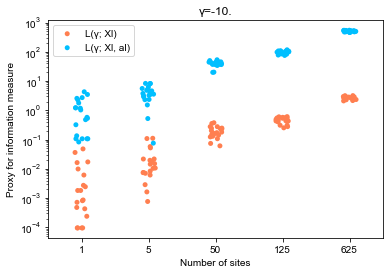

In [435]:
g = sns.stripplot(data=pd.DataFrame(lxlbfq, columns=sites), color='coral', label='L(γ; Xl)')
plt.title('γ=-10.') 
sns.stripplot(data=pd.DataFrame(lxlalbfq, columns=sites), color='deepskyblue', label='L(γ; Xl, al)')
plt.yscale('log', basey=10)
plt.xlabel('Number of sites')
plt.ylabel('Proxy for information measure')
plt.legend(handles=g.get_legend_handles_labels()[0][len(sites)-1:len(sites)+1], labels=g.get_legend_handles_labels()[1][len(sites)-1:len(sites)+1])

In [48]:
np.matmul(lxlalquad.coef, np.vstack((np.repeat(1.0,len(gamma[gamma<0])), gamma[gamma<0], gamma[gamma<0]**2)))

array([-3.08529434e+06, -1.47437817e+06, -7.13349759e+05, -3.51045623e+05,
       -1.76702245e+05, -9.15710456e+04, -4.91897524e+04, -2.75648557e+04,
       -1.61967446e+04, -1.00135259e+04, -6.52586338e+03, -4.48622120e+03,
       -3.25280949e+03, -2.48498703e+03, -1.99552321e+03, -1.67767330e+03,
       -1.46837379e+03, -1.32914435e+03, -1.23585036e+03, -1.17301479e+03,
       -1.13054188e+03, -1.10176160e+03, -1.08222632e+03, -1.06895073e+03,
       -1.05992180e+03])

In [131]:
np.vstack((np.repeat(1.0,len(gamma[gamma<0])), gamma[gamma<0], gamma[gamma<0]**2))

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [-1.00000000e+02, -6.81292100e+01, -4.64158900e+01,
        -3.16227800e+01, -2.15443500e+01, -1.46779900e+01,
        -1.00000000e+01, -6.81292100e+00, -4.64158900e+00,
        -3.16227800e+00, -2.15443500e+00, -1.46779900e+00,
        -1.00000000e+00, -6.81292100e-01, -4.64158900e-01,
        -3.16227800e-01, -2.15443500e-01, -1.46779900e-01,
        -1.00000000e-01, -6.81292100e-02, -4.64158900e-02,
        -3.16227800e-02, -2.15443500e-02, -1.46779900e-02,
        -1.00000000e-02],
    

In [140]:
get_bfq(logxl,g=-10.).coef

array([-589.73624666,  -54.40546589,   -1.00204063])

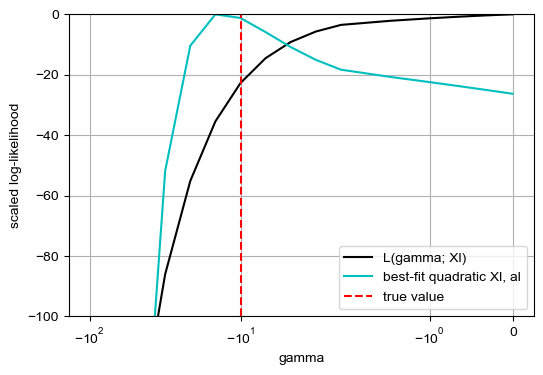

In [141]:
fig = plt.figure(dpi=100)
_ = plt.semilogx(gamma[gamma<0], logxl-np.max(logxl), color='k', label='L(gamma; Xl)')
plt.xscale('symlog')
# _ = plt.semilogx(gamma[gamma<0], logxlal-np.max(logxlal), color='b', label='L(gamma; Xl, al)')
# plt.xscale('symlog')
# lxlbfq = np.matmul(get_bfq(logxl,g=-10.).coef, np.vstack((np.repeat(1.0,len(gamma[gamma<0])), gamma[gamma<0], gamma[gamma<0]**2)))
# _ = plt.semilogx(gamma[gamma<0], lxlbfq-np.max(lxlbfq), color='g', label='best-fit quadratic Xl')
# plt.xscale('symlog')
lxlalbfq = np.matmul(get_bfq(logxlal,g=-10.).coef, np.vstack((np.repeat(1.0,len(gamma[gamma<0])), gamma[gamma<0], gamma[gamma<0]**2)))
_ = plt.semilogx(gamma[gamma<0], lxlalbfq-np.max(lxlalbfq), color='c', label='best-fit quadratic Xl, al')
plt.xscale('symlog')
plt.axvline(x=-10., linestyle='--', color='red', label='true value')
plt.xlabel('gamma')
plt.ylabel('scaled log-likelihood')
plt.legend()
plt.ylim((-100,0))
plt.grid()
plt.show()

### Tweaking the figure from above

1. Add more sites in between - go up to a 1000 (1, 5, 25, 50, 125, 250, 500, 750, 1000)
2. Do a mean + error bar instead of the strip plot
3. Three selection coefs {-100., -10., -1.}

In [72]:
Xlred = np.ravel(dat[np.where(dat[:,1]==-1.),0])
logalred = np.ravel(np.log(dat[np.where(dat[:,1]==-1.),2]))

logxl = np.ravel([get_ll_xl(g, Xlred, N) for g in gamma[gamma<0]])
logxlal = np.ravel([get_ll_alxl([g, Xlred, logalred, prob_model]) for g in gamma[gamma<0]]) + logxl

NameError: name 'get_ll_xl' is not defined

In [268]:
lxlalbfq = []
lxlbfq = []
sites = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
for i in sites:
    for n in np.arange(20):
        rs = np.random.randint(len(Xlred), size=i)
        logxl = np.ravel([get_ll_xl(g, Xlred[rs], N) for g in gamma[gamma<0]])
        logxlal = np.ravel([get_ll_alxl([g, Xlred[rs], logalred[rs], prob_model]) for g in gamma[gamma<0]]) + logxl
        lxlbfq.append(get_bfq(logxl, -1.).coef[2])
        lxlalbfq.append(get_bfq(logxlal, -1.).coef[2])
# data wrangling to convert into an amenable matrix
lxlbfq = np.abs(np.reshape(lxlbfq, [20, len(sites)], order='F'))
lxlalbfq = np.abs(np.reshape(lxlalbfq, [20, len(sites)], order='F'))

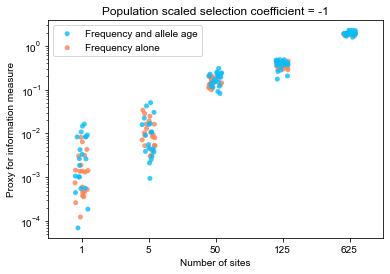

In [84]:
g1 = sns.stripplot(data=pd.DataFrame(lxlbfq, columns=sites), color='coral', label='Frequency alone', alpha=0.8)
g1.set_label('L(γ; Xl)')
# plt.errorbar(sites, np.median(lxlbfq,0), yerr=np.std(lxlbfq,0), color='coral', label='L(γ; Xl)', fmt='-o')
plt.title('Population scaled selection coefficient = -1') 
g2 = sns.stripplot(data=pd.DataFrame(lxlalbfq, columns=sites), color='deepskyblue', label='Frequency and allele age', alpha=0.8)
g2.set_label('L(γ; Xl, al)')
# plt.errorbar(sites, np.median(lxlalbfq,0), yerr=np.std(lxlalbfq,0), color='deepskyblue', label='L(γ; Xl, al)', fmt='-o')
plt.yscale('log', basey=10)
#plt.xscale('log', basex=10)
plt.xlabel('Number of sites')
plt.ylabel('Proxy for information measure')
#plt.ylim([0,10e4])
plt.legend(handles=g1.get_legend_handles_labels()[0][len(sites)-1:len(sites)+1][::-1], labels=g1.get_legend_handles_labels()[1][len(sites)-1:len(sites)+1][::-1])

In [287]:
np.arange(10)[4:6][::-1]

array([5, 4])

### Computing the observed Fisher information

The second derivative of the log-likelihood evaluated at the maximum likelihood estimates (MLE) is the observed Fisher information.   
**The negative Hessian evaluated at the MLE is the same as the observed Fisher information matrix evaluated at the MLE.**   
The estimated standard errors of the MLE (in Hessian) are the square roots of the diagonal elements of the inverse of the observed Fisher information matrix.

In [87]:
import numpy.linalg as lin
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize

In [112]:
# Xlred = np.ravel(np.exp(test_data[np.where(test_data[:,1]==-10),0]))
# logalred = test_labs[np.where(test_data[:,1]==-10)]

hes_ = hessian(get_ll_xl)

# mle_gamma = gamma[gamma<0][np.argmax([get_ll_xl(g) for g in gamma[gamma<0]])]

# transpose or no transpose - same (1x1 matrix cos only 1 param)
# information1 = np.transpose(hes_(mle_gamma))

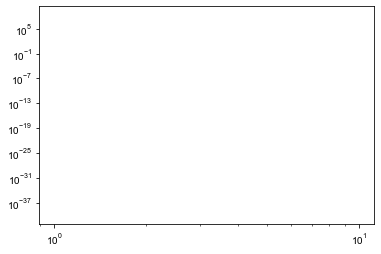

In [104]:
plt.loglog(gamma[gamma<0], np.ravel(hes_across_g), color='k')
#hes_across_g = [hes_(x) for x in gamma[gamma<0]]

In [100]:
hes_across_g

[array(2.1323194e-40),
 array(7.96603265e-27),
 array(1.44075237e-17),
 array(2.55690896e-11),
 array(4.02847496e-07),
 array(0.00025204),
 array(0.01731471),
 array(0.26103085),
 array(1.42278581),
 array(4.35289682),
 array(11.45184531),
 array(32.84839689),
 array(101.47341186),
 array(320.16321807),
 array(1013.12221928),
 array(3205.37955723),
 array(10138.4743825),
 array(32063.22008521),
 array(101395.47487472),
 array(320643.45609655),
 array(1013966.60360839),
 array(3206446.23890502),
 array(10139675.22579973),
 array(32064502.87289842),
 array(1.01396809e+08)]

In [253]:
hes2_ = hessian(get_ll_alxl)

tt = np.zeros(len(gamma[gamma<0]))
for i, g in enumerate(gamma[gamma<0]):
    ahat = prob_model(np.vstack((np.log(Xlred),np.repeat(g,len(Xlred)))).T)
    preds = ahat.mean().numpy()
    preds_sd = ahat.stddev().numpy()
    tt[i] = get_ll_alxl(g)

mle2_gamma = gamma[gamma<0][np.argmax(res)]

information2 = np.transpose(hes2_(mle2_gamma))

In [301]:
from pyhessian import HessianEstimator
import tensorflow.compat.v1 as tf
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.disable_v2_behavior()

In [307]:
hest = HessianEstimator(negloglik, negloglik(test_labs, prob_model.output), prob_model, params, 
                        test_data, test_labs, batch_size_G=1000)

OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

In [454]:
@tf.function
def get_hessian(inputs):
    loss = prob_model(inputs)
    return tf.hessians(loss, inputs)

In [485]:
batch_size=10
hes100 = get_hessian(test_data[np.where(test_data[:,1]==-10),])

ValueError: in user code:

    /var/folders/zd/_6q7nrpj29d_g_j9dsg05c380000gn/T/ipykernel_34395/3930537944.py:3 get_hessian  *
        loss = tf.reduce_sum(prob_model(inputs))
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_6: expected shape=(None, 2), found shape=(1, 145, 2)


In [455]:
batch_size=10
hes100red = get_hessian(test_data[np.where(test_data[:,1]==-10),:])

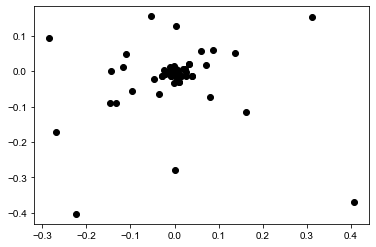

In [459]:
plt.plot(np.ravel(hes100red), np.ravel(hes100), 'o', color='k')

In [465]:
tf.linalg.tensor_diag_part(np.reshape(hes100red, [200, 200]))

<tf.Tensor: shape=(200,), dtype=float64, numpy=
array([-6.17231708e-03, -1.02743419e-04,  4.06681716e-01,  5.63235953e-04,
       -1.32380679e-01, -3.92760092e-04, -1.25289743e-03, -2.08555357e-05,
        3.47475917e-03,  1.03092552e-05,  4.16273065e-03,  5.04317613e-05,
        2.48241937e-03,  2.78729822e-05, -3.74761177e-03, -1.59232703e-03,
       -6.07895781e-04, -4.21063669e-05, -1.17951632e-01, -1.63357792e-04,
       -5.04382115e-05, -8.39586619e-07,  2.59903148e-02,  7.90003687e-05,
       -1.93791452e-03, -3.16892401e-04,  7.23108975e-03,  8.76050981e-05,
        1.61721945e-01,  4.79812559e-04, -6.68994850e-04, -2.84250040e-04,
       -2.69899011e-01, -3.76709923e-03,  6.08895534e-05,  1.94390600e-06,
        4.17612214e-03,  6.95150738e-05,  4.43199533e-04,  9.11870211e-06,
       -1.52640408e-04, -2.63307720e-06, -1.47360489e-01, -4.37203562e-04,
       -2.34963559e-02, -2.32644728e-04, -5.72291901e-05, -9.87214548e-07,
        3.13076258e-01,  2.75080698e-03, -3.55811743

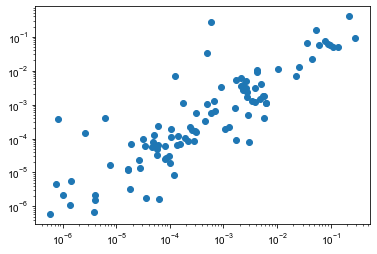

In [483]:
# shows pretty good correlation
plt.loglog(np.abs(tf.linalg.tensor_diag_part(np.reshape(hes100red, [200, 200]))[100:200]), np.abs(tf.linalg.tensor_diag_part(np.reshape(hes100, [200, 200]))[100:200]), 'o')

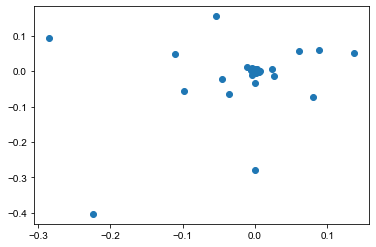

In [479]:

#np.corrcoef(hes100[0][:,1,0,0], hes100[0][:,1,0,0])